In [1]:
import datetime
import pickle

import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
import matplotlib.pyplot as plt

In [2]:
def make_data_blocks(dataset, start_index, end_index, history_size, target_size,
                     steps_ahead=0, target=None, step=1):
    data = []
    labels = []

    if target is None:
        univariate = True
    else:
        univariate = False

    start_index = start_index + history_size
    if end_index is None or end_index >= len(dataset) - (target_size + steps_ahead) + 1:
        end_index = len(dataset) - (target_size + steps_ahead) + 1

    for i in range(start_index, end_index):
        indices = range(i - history_size, i, step)
        if univariate:
            # Reshape data from (history_size,) to (history_size, 1)
            data.append(np.reshape(dataset[indices], (history_size, 1)))
            labels.append(dataset[i + steps_ahead : i + steps_ahead + target_size])
        else:
            data.append(dataset[indices])
            labels.append(target[i + steps_ahead : i + steps_ahead + target_size])
    return np.array(data), np.array(labels)

In [3]:
def show_plot(plot_data, delta, title):
    create_time_steps = lambda length: list(range(-length, 0))
    labels = ['History', 'True Future', 'Model Prediction']
    marker = ['.-', 'rs', 'go']
    time_steps = create_time_steps(plot_data[0].shape[0])
    future = np.array(delta)

    plt.title(title)
    for i, x in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=8, markerfacecolor='w',
                     markeredgewidth=2, label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
    plt.legend()
    plt.xlim([time_steps[0], (future.max()+5)*2])
    plt.xlabel('Time-Step')
    return plt

In [4]:
time_step = 15 # [minutes]
data = pickle.load(open('data1.pkl', 'rb'))
df = data['full']['building_energy']

t0 = datetime.datetime.combine(datetime.date.today(), df['datetime'][0].to_pydatetime().time())
t1 = datetime.datetime.combine(datetime.date.today(), df['datetime'][1].to_pydatetime().time())
orig_time_step = int((t1 - t0).total_seconds() / 60) # [min]
avg_step = time_step // orig_time_step

df['consumption_averaged'] = df['consumption'].rolling(window=avg_step).mean()
df['generation_averaged'] = df['generation'].rolling(window=avg_step).mean()
df['minute'] = [(dt.hour * 60 + dt.minute) for dt in df['datetime']]
df['workday'] = np.logical_not(df['weekend'] | df['holiday'])
cols = df.columns.tolist()
cols = cols[:1] + cols[-2:] + cols[1:-2]
df = df[cols]
df = df[avg_step - 1 : : avg_step]

samples_per_day = 24 * 60 // time_step
n_samples = df.shape[0]
n_days = n_samples // samples_per_day
t = np.arange(samples_per_day) * time_step / 60
print(f'Time step: {time_step} minutes.')
print(f'Number of days: {n_days}.')
print(f'Samples per day: {samples_per_day}.')

Time step: 15 minutes.
Number of days: 365.
Samples per day: 96.


(25856640, 25859520)

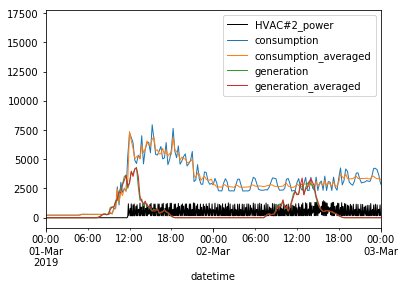

In [5]:
fig,ax = plt.subplots(1, 1)
data['full']['zones'][2].plot(x='datetime', y='HVAC#2_power', color='k', lw=1, ax=ax)
df.plot(x='datetime', y=['consumption','consumption_averaged','generation','generation_averaged'], lw=1, ax=ax)
start = pd.Timestamp(year=2019, month=3, day=1)
stop = pd.Timestamp(year=2019, month=3, day=3)
# plt.ylim([-100,6000])
ax.set_xlim([start,stop])

In [6]:
df.head()

,datetime,minute,workday,weekday,weekend,holiday,consumption,generation,consumption_averaged,generation_averaged
2,2019-01-01 00:15:00,15,False,1,False,True,2266,0,2503.000000,0.0
5,2019-01-01 00:30:00,30,False,1,False,True,2253,0,2511.333333,0.0
8,2019-01-01 00:45:00,45,False,1,False,True,2249,0,2488.000000,0.0
11,2019-01-01 01:00:00,60,False,1,False,True,2251,0,2488.333333,0.0
14,2019-01-01 01:15:00,75,False,1,False,True,2250,0,2467.000000,0.0


In [7]:
df.iloc[5680,:]

datetime                2019-03-01 04:15:00
minute                                  255
workday                                True
weekday                                   4
weekend                               False
holiday                               False
consumption                             210
generation                                0
consumption_averaged                215.333
generation_averaged                       0
Name: 17042, dtype: object

In [8]:
idx, = np.where([dt.seconds > 900 or dt.days > 0 for dt in df['datetime'].diff()])

In [9]:
len(idx)

0

In [10]:
n_days_training = int(0.8 * n_days)
n_days_validation = int(0.1 * n_days)
n_days_test = n_days - n_days_training - n_days_validation
TRAIN_SPLIT = n_days_training * samples_per_day
VALIDATION_SPLIT = (n_days_training + n_days_validation) * samples_per_day
print('We will use the first {} measurements (corresponding to {} days) to train the network.'.\
      format(TRAIN_SPLIT, n_days_training))
print('We will use the subsequent {} measurements (corresponding to {} days) to validate the network.'.\
      format(VALIDATION_SPLIT - TRAIN_SPLIT, n_days_validation))
print('We will use the final {} measurements (corresponding to {} days) to validate the network.'.\
      format(n_days_test * samples_per_day, n_days_test))

We will use the first 28032 measurements (corresponding to 292 days) to train the network.
We will use the subsequent 3456 measurements (corresponding to 36 days) to validate the network.
We will use the final 3552 measurements (corresponding to 37 days) to validate the network.


In [11]:
cols = ['consumption_averaged','generation_averaged']
# cols = ['consumption_averaged']
x = df[cols].to_numpy(dtype=np.float32)
x = np.reshape(x, [n_days, samples_per_day, x.shape[1]])
x_train_max = np.max(x[:TRAIN_SPLIT, :, :], axis=(0, 1))
x_train_min = np.min(x[:TRAIN_SPLIT, :, :], axis=(0, 1))
x_scaled = np.array([np.ndarray.flatten(-1 + 2 * (x[:,:,i] - m) / (M - m))
                         for i,(M,m) in enumerate(zip(x_train_max, x_train_min))]).T
x_scaled.shape

(35040, 2)

In [12]:
encoder = OneHotEncoder(categories='auto')
cols = ['minute','weekday','workday']
encoder.fit(df[cols].to_numpy())
categorical = encoder.transform(df[cols].to_numpy()).toarray()
categorical.shape

(35040, 105)

In [13]:
# length of history to use for prediction
history_size = int(samples_per_day / 1)
# how many steps to predict in the future
target_size = 1 * 60 // time_step
# how many steps to look ahead
steps_ahead = 0

X = np.concatenate((x_scaled, categorical), axis=1)

x_train, y_train = make_data_blocks(X, 0, TRAIN_SPLIT, history_size, target_size,
                                    steps_ahead, target=X[:,0])
x_val,   y_val   = make_data_blocks(X, TRAIN_SPLIT, VALIDATION_SPLIT, history_size,
                                    target_size, steps_ahead, target=X[:,0])
x_test,  y_test  = make_data_blocks(X, VALIDATION_SPLIT, None, history_size,
                                    target_size, steps_ahead, target=X[:,0])

In [14]:
x_train.shape

(27936, 96, 107)

In [15]:
y_train.shape

(27936, 4)

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/site-packages/matplotlib/pyplot.py'>

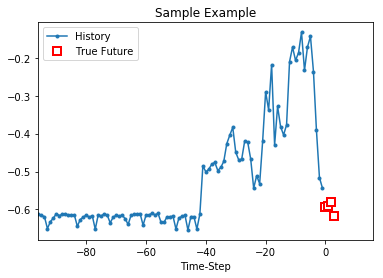

In [16]:
i = 170
show_plot([x_train[i, :, 0], y_train[i]], np.arange(target_size), 'Sample Example')

In [17]:
BATCH_SIZE = 256
BUFFER_SIZE = 10000
train = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
val = tf.data.Dataset.from_tensor_slices((x_val, y_val))
val = val.batch(BATCH_SIZE).repeat()

In [18]:
n_layers = 3
n_units = [15 for _ in range(n_layers)]

inputs = tf.keras.Input(shape=x_train.shape[-2:], name='input')
for n in n_units[:-1]:
    try:
        lyr = tf.keras.layers.LSTM(n, return_sequences=True)(lyr)
    except:
        lyr = tf.keras.layers.LSTM(n, return_sequences=True)(inputs)
try:
    lyr = tf.keras.layers.LSTM(n_units[-1])(lyr)
except:
    lyr = tf.keras.layers.LSTM(n_units[-1])(inputs)
outputs = tf.keras.layers.Dense(target_size)(lyr)

RNN = tf.keras.Model(inputs=inputs, outputs=outputs)

RNN.compile(optimizer='adam', loss='mae')
RNN.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 96, 107)]         0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 96, 15)            7380      
_________________________________________________________________
lstm_2 (LSTM)                (None, 96, 15)            1860      
_________________________________________________________________
lstm_3 (LSTM)                (None, 15)                1860      
_________________________________________________________________
dense (Dense)                (None, 4)                 64        
Total params: 11,164
Trainable params: 11,164
Non-trainable params: 0
_________________________________________________________________


In [ ]:
EVALUATION_INTERVAL = 1000
EPOCHS = 5
history = RNN.fit(train, epochs=EPOCHS, steps_per_epoch=EVALUATION_INTERVAL, validation_data=val, validation_steps=50)

In [ ]:
train_loss = RNN.evaluate(x_train, y_train, verbose=0)
val_loss   = RNN.evaluate(x_val,   y_val,   verbose=0)
test_loss  = RNN.evaluate(x_test,  y_test,  verbose=0)
print('Loss on the training set ..... {:.4f}.'.format(train_loss))
print('Loss on the validation set ... {:.4f}.'.format(val_loss))
print('Loss on the test set ......... {:.4f}.'.format(test_loss))

In [ ]:
test_prediction = RNN.predict(x_test)
val_prediction = RNN.predict(x_val)
days_test = np.arange(y_test.shape[0]) / samples_per_day
days_val = np.arange(y_val.shape[0]) / samples_per_day

In [ ]:
i = 3000
y_pred = RNN.predict(x_test[i:i+1, :, :]).squeeze()
show_plot([x_test[i, :, 0], y_test[i], y_pred], np.arange(target_size), 'Sample Example')

In [ ]:
fun = lambda y,M,m: m + (M - m) / 2 * (y + 1)

i = 0
fig,(ax1,ax2) = plt.subplots(2, 1, figsize=(15,10))
ax1.plot(days_val, fun(y_val[:,i], x_train_max[0], x_train_min[0]), 'k', label='Measured')
ax1.plot(days_val, fun(val_prediction[:,i], x_train_max[0], x_train_min[0]), 'r', label='Predicted')
ax1.set_title('Validation set')
ax1.set_ylabel('Energy consumption [kWh]')
ax1.set_xticks(np.arange(int(np.ceil(days_val[-1])) + 1))

ax2.plot(days_test, fun(y_test[:,i], x_train_max[0], x_train_min[0]), 'k', label='Measured')
ax2.plot(days_test, fun(test_prediction[:,i], x_train_max[0], x_train_min[0]), 'r', label='Predicted')
ax2.set_title('Test set')
ax2.set_xlabel('Days')
ax2.set_ylabel('Energy consumption [kWh]')
ax2.legend(loc='best')
# ax2.set_xlim([6, 8])
ax2.set_xticks(np.arange(int(np.ceil(days_test[-1])) + 1));